In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px

np.random.seed(9)

Improvement over Linear Regression

Ridge regression adds an extra term 

In [2]:
data = pd.read_csv(r"Housing.csv")
data  

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [3]:
data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [4]:
# Convert categorical to numerical features

categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
cat_encodes = {'yes': 1,
               'no': 0}
furnished_stat = ['furnishingstatus']
f_encodes = {
    'furnished': 1,
    'semi-furnished' : 0,
    'unfurnished': -1
}

# Replace all 'yes' with 1 and 'no' with 0 in categorical columns
data[categorical] = data[categorical].replace(cat_encodes)
data[furnished_stat] = data[furnished_stat].replace(f_encodes)

# Display the updated dataframe
data

/var/folders/v0/6fl9_2q93mggh30x_qf5fyv40000gn/T/ipykernel_65453/388020242.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[categorical] = data[categorical].replace(cat_encodes)
/var/folders/v0/6fl9_2q93mggh30x_qf5fyv40000gn/T/ipykernel_65453/388020242.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[furnished_stat] = data[furnished_stat].replace(f_encodes)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,-1
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,0
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,-1
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1


In [5]:
def test_train_val_split(data, train_split, test_split, val_split):
    
    cols = data.columns
    data = np.array(data)
    
    num_samples = len(data)
    
    indices = np.random.permutation(num_samples)
    
    train_split_indx = int(num_samples * train_split)
    test_split_indx = train_split_indx + int(num_samples * test_split)
    val_split_indx = test_split_indx + int(num_samples*val_split)
    
    train  = data[indices[:train_split_indx]]
    test = data[indices[train_split_indx: test_split_indx]]
    validation = data[indices[test_split_indx: val_split_indx]]
    
    # # Convert numpy arrays back to DataFrames
    # train_df = pd.DataFrame(train, columns=cols)
    # test_df = pd.DataFrame(test, columns=cols)
    # validation_df = pd.DataFrame(validation, columns=cols)
    
    return train, test, validation
    
train, test, valid = test_train_val_split(data, 0.8, 0.1, 0.1)

In [6]:
# Standardize

def standardize(train, test, valid):
    mean = np.mean(train, axis = 0)
    stdev = np.std(train, axis = 0)
    
    train = (train-mean)/stdev    
    test = (test-mean)/stdev   
    valid = (valid-mean)/stdev   
    
    return train, test, valid


def min_max_scaling(train, test, valid):
    min_val = np.min(train, axis=0)
    max_val = np.max(train, axis=0)
    
    train = (train - min_val) / (max_val - min_val)
    test = (test - min_val) / (max_val - min_val)
    valid = (valid - min_val) / (max_val - min_val)
    
    return train, test, valid

In [7]:
def split_features_target(data):
    target = data[:, 0]
    features = data[:, 1:len(data[0])]
    return features, target

# X, y = split_features_target(train)

train, train_target = split_features_target(train)
test, test_target = split_features_target(test)
valid, valid_target = split_features_target(valid)

In [8]:
# train, test, valid = standardize(train, test, valid)
train, test, valid = min_max_scaling(train, test, valid)

In [9]:
class LassoRegression:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        # self.stopping_threshold = stopping_threshold
        self.W = None
        self.B = None
        
    def initialise_params(self, n_features):
        self.W = np.random.randn(n_features)*0.01
        self.B = 0
        
    def forward_pass(self, X):
        return np.dot(X, self.W) + self.B
    
    # Loss functions
    def mse_error_fn(self, predictions, y):
        m = len(predictions)
        error = np.sum(np.square(predictions - y))/(2 * m)
        return np.log(error)
    
    def r2_score(self, predictions, y):
        m = len(predictions)
        mean_y = np.mean(y)
        r2 = 1 - ((np.square(y - predictions))/(np.square(y - mean_y)))
        return np.mean(r2)
    
    def lasso_regularization(self, predictions, y, penalty_control = 0.5):
        lasso_loss = self.mse_error_fn(predictions, y) + np.multiply(penalty_control, abs(np.sum((self.W))))
        return np.log(lasso_loss)
        
    
    def backprop(self, predictions, y):
        m = len(predictions)
        
        self.dl_dw = np.dot((predictions - y), self.X)/m 
        self.dl_db = np.sum(predictions - y)/m
        
    
    def fitting(self, X, y, iters):
        
        self.X = X
        self.y = y
        
        self.initialise_params(X.shape[1])
        
        costs = []
        
        for i in range(iters):
            predictions = self.forward_pass(X)
            
            penalty_control = 0.
            cost = self.lasso_regularization(predictions, y, penalty_control)
            r2 = self.r2_score(predictions, y)
            
            self.backprop(predictions, y)
            
            self.W -= self.learning_rate*self.dl_dw
            self.B -= self.learning_rate*self.dl_db
            
            costs.append(cost)
            
            
            if i % 2 == 0:
                print(f"Iteration: {i}  Loss: {cost} R^2: {r2}")
                
            # if i > 0 and abs(costs[-1] - costs[-2]) < self.stopping_threshold:
            #     print(f"Converged after {i} iterations")
            #     break  
            
        return costs
            
    def plot_lc(self, costs):
        plt.plot(costs)
        plt.title('Learning Curve (Cost vs. Iterations) - Lasso Regression')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.show()
        
    def plot(self, data_x, data_y):
        # Get the predictions from the model
        preds = self.forward_pass(data_x)
        
        # Sort data based on actual values for better visualization
        sorted_indices = np.argsort(data_y)
        sorted_data_y = data_y[sorted_indices]
        sorted_preds = preds[sorted_indices]
        
        # Scatter plot of Actual vs. Predicted values
        plt.scatter(sorted_data_y, sorted_preds, color='blue', label='Predicted vs Actual')
        
        # Add a reference diagonal (y = x)
        min_val = min(sorted_data_y.min(), sorted_preds.min())
        max_val = max(sorted_data_y.max(), sorted_preds.max())
        plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label='Ideal Fit (y=x)')
        
        # Set the title and labels
        plt.title('Actual vs. Predicted - Lasso')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        
        # Show the legend
        plt.legend()
        
        # Display the plot
        plt.show()
            
    def evaluate(self, data_x, data_y):
        preds = self.forward_pass(data_x)
        cost = self.mse_error_fn(preds, data_y)
        r2 = self.r2_score(preds, data_y)
        print(f"Loss: {cost} R2: {r2}")
        
    def predict_one(self, x):
        prediction = self.forward_pass(x)
        return prediction
        
        

In [10]:
rr = LassoRegression(0.1)

losses = rr.fitting(train, train_target, 100)

Iteration: 0  Loss: 3.4090100639591143 R^2: -1373.3637404288736
Iteration: 2  Loss: 3.3688563162973115 R^2: -273.30277210361965
Iteration: 4  Loss: 3.338593346325441 R^2: -48.20616482952867
Iteration: 6  Loss: 3.323051233846884 R^2: -18.172094109281737
Iteration: 8  Loss: 3.317400970611547 R^2: -24.359749491832183
Iteration: 10  Loss: 3.3155063149228026 R^2: -33.11459480845726
Iteration: 12  Loss: 3.314708523861335 R^2: -39.1902221874152
Iteration: 14  Loss: 3.3142120924090035 R^2: -42.90165144411719
Iteration: 16  Loss: 3.313804450058022 R^2: -45.15564748934484
Iteration: 18  Loss: 3.3134301834329327 R^2: -46.59855527115435
Iteration: 20  Loss: 3.3130746079053806 R^2: -47.60424315708199
Iteration: 22  Loss: 3.312733500633149 R^2: -48.37353604153935
Iteration: 24  Loss: 3.3124053356566807 R^2: -49.01101836718393
Iteration: 26  Loss: 3.312089298466435 R^2: -49.57049761634624
Iteration: 28  Loss: 3.31178477817275 R^2: -50.07962605292956
Iteration: 30  Loss: 3.3114912368903875 R^2: -50.55

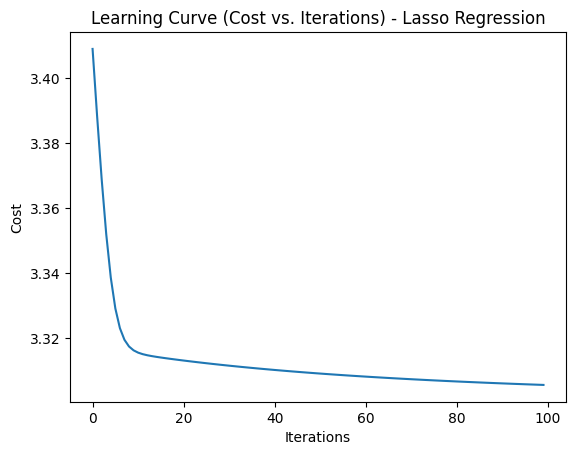

In [11]:
rr.plot_lc(losses)

In [12]:
rr.evaluate(test, test_target)

Loss: 26.857557097431584 R2: -0.48701650834105437


In [13]:
rr.evaluate(valid, valid_target)

Loss: 27.099573309232913 R2: -43.98033933818493


In [14]:
rr.evaluate(train, train_target)

Loss: 27.262711926915397 R2: -57.715197867137995


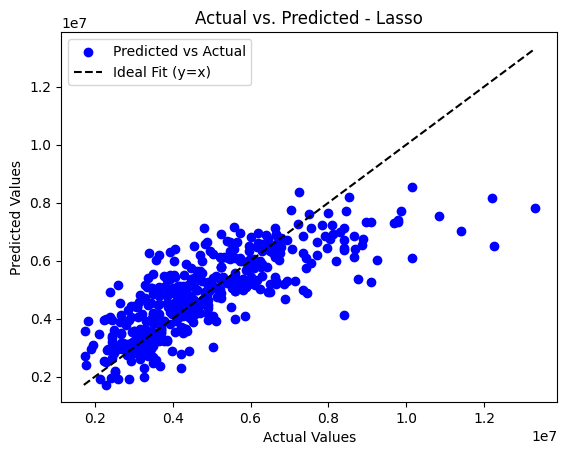

In [15]:
rr.plot(train, train_target)

In [16]:
rr.predict_one(valid[0])

np.float64(4206149.4028807655)

In [17]:
valid_target[0]

np.int64(4200000)

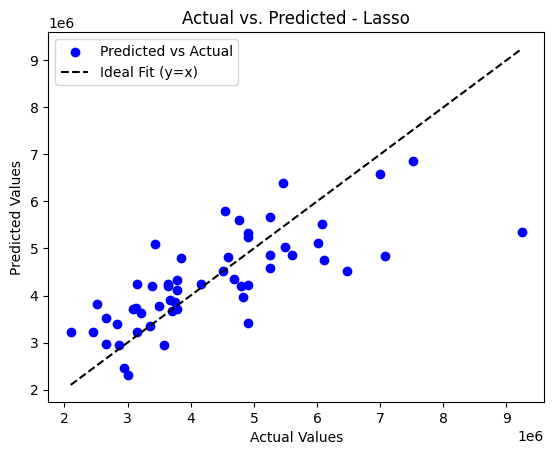

In [18]:
rr.plot(test, test_target)

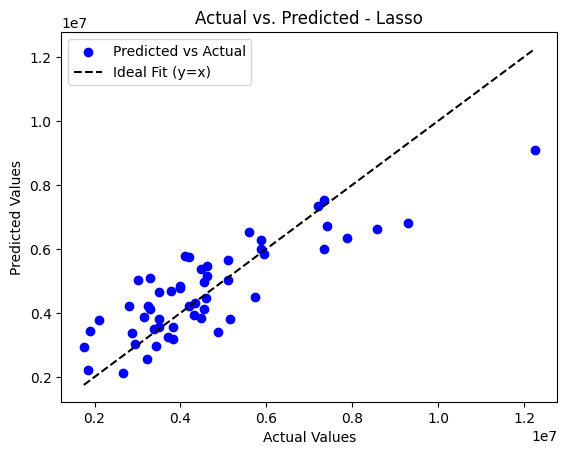

In [19]:
rr.plot(valid, valid_target)

## Elastic Net regression

Ridge + lasso

In [29]:
class ElasticNetRegression:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        # self.stopping_threshold = stopping_threshold
        self.W = None
        self.B = None
        
    def initialise_params(self, n_features):
        self.W = np.random.randn(n_features)*0.01
        self.B = 0
        
    def forward_pass(self, X):
        return np.dot(X, self.W) + self.B
    
    # Loss functions
    def mse_error_fn(self, predictions, y):
        m = len(predictions)
        error = np.sum(np.square(predictions - y))/(2 * m)
        return error
    
    def r2_score(self, predictions, y):
        m = len(predictions)
        mean_y = np.mean(y)
        r2 = 1 - ((np.square(y - predictions))/(np.square(y - mean_y)))
        return np.mean(r2)
    
    def lasso_regularization(self, predictions, y, penalty_control = 0.5):
        lasso_loss = np.multiply(penalty_control, abs(np.sum((self.W))))
        return lasso_loss
    
    def ridge_regularization(self, predictions, y, penalty_control = 0.5):
        ridge_loss = np.multiply(penalty_control, np.sum(np.square(self.W)))
        return ridge_loss
    
    def elasticnet_regularization(self, predictions, y, p1, p2):
        return np.log(self.mse_error_fn(predictions, y) + self.ridge_regularization(predictions, y, p1) + self.lasso_regularization(predictions, y, p2))
        
    
    def backprop(self, predictions, y):
        m = len(predictions)
        
        self.dl_dw = np.dot((predictions - y), self.X)/m  + (np.mean(self.W))
        self.dl_db = np.sum(predictions - y)/m
        
    
    def fitting(self, X, y, iters):
        
        self.X = X
        self.y = y
        
        self.initialise_params(X.shape[1])
        
        costs = []
        
        for i in range(iters):
            predictions = self.forward_pass(X)
            
            penalty_control = 0.5
            cost = self.elasticnet_regularization(predictions, y,0.5, 0.5)
            r2 = self.r2_score(predictions, y)
            
            self.backprop(predictions, y)
            
            self.W -= self.learning_rate*self.dl_dw
            self.B -= self.learning_rate*self.dl_db
            
            costs.append(cost)
            
            
            if i % 2 == 0:
                print(f"Iteration: {i}  Loss: {cost} R^2: {r2}")
                
            # if i > 0 and abs(costs[-1] - costs[-2]) < self.stopping_threshold:
            #     print(f"Converged after {i} iterations")
            #     break  
            
        return costs
            
    def plot_lc(self, costs):
        plt.plot(costs)
        plt.title('Learning Curve (Cost vs. Iterations) - Lasso Regression')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.show()
        
    def plot(self, data_x, data_y):
        # Get the predictions from the model
        preds = self.forward_pass(data_x)
        
        # Sort data based on actual values for better visualization
        sorted_indices = np.argsort(data_y)
        sorted_data_y = data_y[sorted_indices]
        sorted_preds = preds[sorted_indices]
        
        # Scatter plot of Actual vs. Predicted values
        plt.scatter(sorted_data_y, sorted_preds, color='blue', label='Predicted vs Actual')
        
        # Add a reference diagonal (y = x)
        min_val = min(sorted_data_y.min(), sorted_preds.min())
        max_val = max(sorted_data_y.max(), sorted_preds.max())
        plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label='Ideal Fit (y=x)')
        
        # Set the title and labels
        plt.title('Actual vs. Predicted - Lasso')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        
        # Show the legend
        plt.legend()
        
        # Display the plot
        plt.show()
            
    def evaluate(self, data_x, data_y):
        preds = self.forward_pass(data_x)
        cost = self.mse_error_fn(preds, data_y)
        r2 = self.r2_score(preds, data_y)
        print(f"Loss: {cost} R2: {r2}")
        
    def predict_one(self, x):
        prediction = self.forward_pass(x)
        return prediction
        
        

In [32]:
en = ElasticNetRegression(0.01)

losses = en.fitting(train, train_target, 100)

Iteration: 0  Loss: 30.23529842423015 R^2: -1373.363742229092
Iteration: 2  Loss: 30.126879045706623 R^2: -1202.6692383939348
Iteration: 4  Loss: 30.02233976679263 R^2: -1053.8049025133978
Iteration: 6  Loss: 29.921940166206593 R^2: -923.9409877612318
Iteration: 8  Loss: 29.825920226019 R^2: -810.6178212080171
Iteration: 10  Loss: 29.73449291667518 R^2: -711.697116986729
Iteration: 12  Loss: 29.647837055778783 R^2: -625.3197199861654
Iteration: 14  Loss: 29.56609090894624 R^2: -549.8689285563499
Iteration: 16  Loss: 29.48934699537279 R^2: -483.93865764964727
Iteration: 18  Loss: 29.41764850121513 R^2: -426.30580176604036
Iteration: 20  Loss: 29.350987592674596 R^2: -375.9062420129516
Iteration: 22  Loss: 29.289305769635167 R^2: -331.8140152565063
Iteration: 24  Loss: 29.232496229818345 R^2: -293.22322723002634
Iteration: 26  Loss: 29.18040804679901 R^2: -259.43234687554946
Iteration: 28  Loss: 29.132851826108595 R^2: -229.83056725144615
Iteration: 30  Loss: 29.089606409517504 R^2: -203

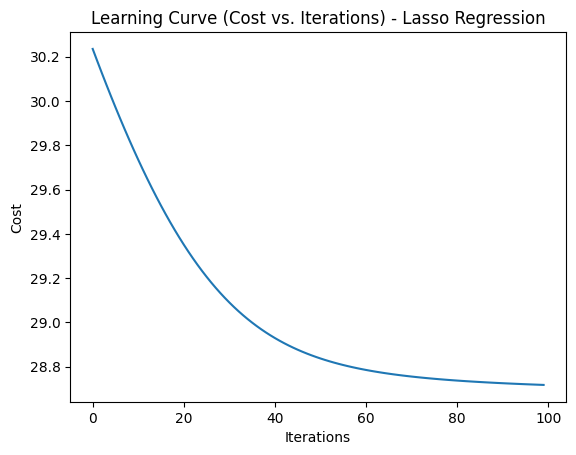

In [33]:
en.plot_lc(losses)

In [34]:
en.evaluate(test, test_target)

Loss: 754802736386.0057 R2: -0.03815669084609286


In [35]:
en.evaluate(valid, valid_target)

Loss: 1260924948107.3237 R2: -27.079222116402452


In [36]:
en.evaluate(train, train_target)

Loss: 1331771390531.5076 R2: -14.388148162980183


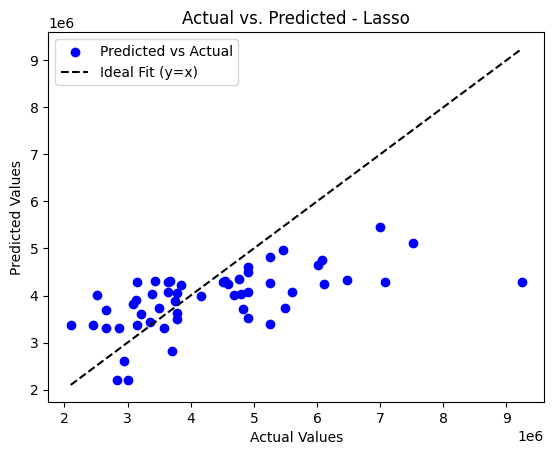

In [37]:
en.plot(test, test_target)

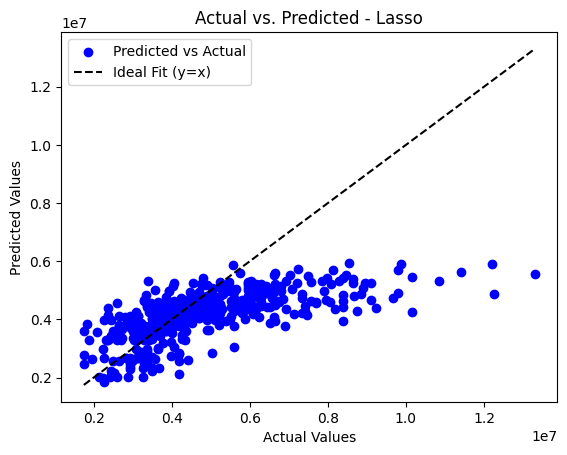

In [38]:
en.plot(train, train_target)

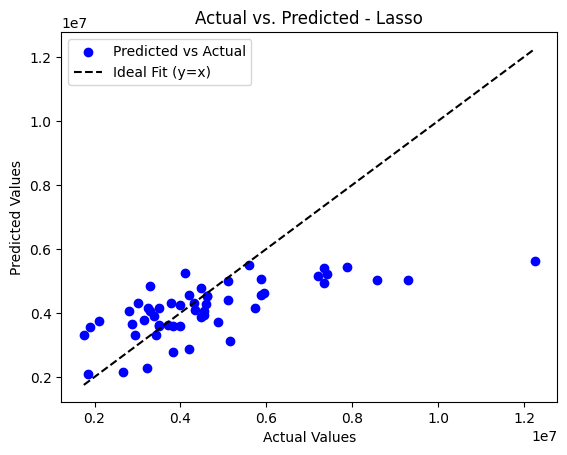

In [40]:
en.plot(valid, valid_target)